In [1]:
#LIBRERIAS Y MIERDAS

import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta
import seaborn as sns


import fastf1
import fastf1.plotting
from fastf1.core import Laps
import statistics as st


In [9]:
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')


In [2]:
### FUNCIONES


#QUALIFYING LAP TIME COMPARISION

def qual_comparision(año, race):

    # # Enable Matplotlib patches for plotting timedelta values
    fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                            color_scheme='fastf1')


    session = fastf1.get_session(año, race, 'Q')
    session.load()

    drivers = pd.unique(session.laps['Driver'])

    list_fastest_laps = list()
    for drv in drivers:
        drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
        list_fastest_laps.append(drvs_fastest_lap)
    fastest_laps = Laps(list_fastest_laps) \
        .sort_values(by='LapTime') \
        .reset_index(drop=True)

    pole_lap = fastest_laps.pick_fastest()
    fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

    team_colors = list()
    for index, lap in fastest_laps.iterlaps():
        color = fastf1.plotting.get_team_color(lap['Team'], session=session)
        team_colors.append(color)

    fig, ax = plt.subplots()
    ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
            color=team_colors, edgecolor='grey')
    ax.set_yticks(fastest_laps.index)
    ax.set_yticklabels(fastest_laps['Driver'])

    # show fastest at the top
    ax.invert_yaxis()

    # draw vertical lines behind the bars
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

    lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

    plt.suptitle(f"{session.event['EventName']} {session.event.year} Qualifying\n"
                f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

    plt.show()


#CREATE A PROGESSION GRAPH SHOWING THE POSITIONS FOR ALL DRIVERS IN A GIVEN RACE
def position_changes(año, carrera):

    fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')
    
    session = fastf1.get_session(año, carrera, 'R')
    session.load(telemetry=False, weather=False)

    fig, ax = plt.subplots(figsize=(13.0, 6.9))
    
    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)
        

        abb = drv_laps['Driver'].iloc[0]
        style = fastf1.plotting.get_driver_style(identifier=abb,
                                                style=['color', 'linestyle'],
                                                session=session)

        ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
                label=abb, **style)
        
    ax.set_ylim([20.5, 0.5])
    ax.set_yticks(range(1,21))
    ax.set_xlabel('Lap')
    ax.set_ylabel('Position')
    ax.set_xticks(range(1, (session.total_laps)+1))
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    plt.tight_layout()

    plt.show()

#COMPARE THE LAPTIMES OF N DRIVERS ALONG A RACE SESSION
def drivers_laptime_comp(año, carrera, pilotos):
    
    fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')
    race = fastf1.get_session(año, carrera, 'R')
    race.load()


    fig, ax = plt.subplots(figsize=(8, 5))

    for driver in (pilotos):
        laps = race.laps.pick_driver(driver).pick_quicklaps().reset_index()
        style = fastf1.plotting.get_driver_style(identifier=driver,
                                        style=['color', 'linestyle'],
                                        session=race)
        ax.plot(laps['LapTime'], **style, label=driver)

    # add axis labels and a legend
    ax.set_xlabel("Lap Number")
    ax.set_ylabel("Lap Time")
    ax.legend()

#OVERLAP THE SPEED GRAPH OF 2 DRIVERS IN A QUALIFYING SESSION LAP
def overlap_speed(año, carrera, prueba, piloto1, piloto2):
    
    fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

    # load a session and its telemetry data
    session = fastf1.get_session(año, carrera, prueba)
    session.load()

    pil1_lap = session.laps.pick_driver(piloto1).pick_fastest()
    pil2_lap = session.laps.pick_driver(piloto2).pick_fastest()

    tel1 = pil1_lap.get_car_data().add_distance()
    tel2 = pil2_lap.get_car_data().add_distance()


    color1= fastf1.plotting.get_team_color(pil1_lap['Team'], session=session)
    color2 = fastf1.plotting.get_team_color(pil2_lap['Team'], session=session)

    fig, ax = plt.subplots()
    ax.plot(tel1['Distance'], tel1['Speed'], color=color1, label=piloto1)
    ax.plot(tel2['Distance'], tel2['Speed'], color=color2, label=piloto2)

    ax.set_xlabel('Distance in m')
    ax.set_ylabel('Speed in km/h')

    ax.legend()
    plt.suptitle(f"Fastest Lap Comparison \n "
                f"{session.event['EventName']} {session.event.year} Qualifying")

    plt.show()

#COMPARE AND PLOT THE TEAM PACE OF A GIVEN RACE FOR ALL TEAMS (BOXPLOT)
def team_pace_comp_boxplot(año, carrera):
    fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False,
                          color_scheme='fastf1')
    
    race = fastf1.get_session(año, carrera, 'R')
    race.load()
    laps = race.laps.pick_quicklaps()

    transformed_laps = laps.copy()
    transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

    # order the team from the fastest (lowest median lap time) tp slower
    team_order = (
        transformed_laps[["Team", "LapTime (s)"]]
        .groupby("Team")
        .median()["LapTime (s)"]
        .sort_values()
        .index
    )
    print(team_order)

    # make a color palette associating team names to hex codes
    team_palette = {team: fastf1.plotting.get_team_color(team, session=race)
                    for team in team_order}
    

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(
        data=transformed_laps,
        x="Team",
        y="LapTime (s)",
        hue="Team",
        order=team_order,
        palette=team_palette,
        whiskerprops=dict(color="white"),
        boxprops=dict(edgecolor="white"),
        medianprops=dict(color="grey"),
        capprops=dict(color="white"),
    )

    plt.title(f" {año} {carrera}")
    plt.grid(visible=False)

    # x-label is redundant
    ax.set(xlabel=None)
    plt.tight_layout()
    plt.show()


#COMPARE AND PLOT THE TEAM PACE OF A GIVEN RACE FOR ALL TEAMS (ViOLINPLOT)
def team_pace_comp_violin(año, carrera):
    race = fastf1.get_session(año, carrera, 'R')
    race.load()
    laps = race.laps.pick_quicklaps()

    transformed_laps = laps.copy()
    transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

    # order the team from the fastest (lowest median lap time) tp slower
    team_order = (
        transformed_laps[["Team", "LapTime (s)"]]
        .groupby("Team")
        .mean()["LapTime (s)"]
        .sort_values()
        .index
    )

    mean_lap = transformed_laps['LapTime (s)'].mean()

   
    # make a color palette associating team names to hex codes
    team_palette = {team: fastf1.plotting.get_team_color(team, session=race)
                    for team in team_order}

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.violinplot(
        data=transformed_laps,
        x="Team",
        y="LapTime (s)",
        hue="Team",
        inner=None,
        density_norm="area",
        order=team_order,
        palette=team_palette
    )

    sns.swarmplot(
        data=transformed_laps,
        x="Team",
        y="LapTime (s)",
        hue =  'Compound', 
        order=team_order,
        palette=fastf1.plotting.get_compound_mapping(session=race), 
        hue_order=["SOFT", "MEDIUM", "HARD"],
        linewidth=0,
        size=4
    )

    plt.title(f" {año} {carrera}")
    plt.grid(visible=False)

    # x-label is redundant
    ax.set(xlabel=None)
    ax.axhline(y=mean_lap, color='red', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.show()

#COMPARE AND PLOT THE DRIVER PACE OF A GIVEN RACE FOR ALL TEAMS (ViOLINPLOT)
def driver_pace_comp_violin(año, carrera):
    race = fastf1.get_session(año, carrera, 'R')
    race.load()
    laps = race.laps.pick_quicklaps()
    classification = pd.Series(data = list(race.results.ClassifiedPosition), index = race.results.Abbreviation)
    classification

    transformed_laps = laps.copy()
    transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

    mean_lap = transformed_laps['LapTime (s)'].mean()

   
    # make a color palette associating team names to hex codes
    team_palette = {team: fastf1.plotting.get_team_color(team, session=race)
                    for team in transformed_laps['Team']}

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.violinplot(
        data=transformed_laps,
        x="Driver",
        y="LapTime (s)",
        hue="Team",
        inner=None,
        density_norm="area",
        order=classification.index,
        palette=team_palette
    )

    sns.swarmplot(
        data=transformed_laps,
        x="Driver",
        y="LapTime (s)",
        hue =  'Compound', 
        order=classification.index,
        palette=fastf1.plotting.get_compound_mapping(session=race), 
        hue_order=["SOFT", "MEDIUM", "HARD"],
        linewidth=0,
        size=4
    )

    plt.title(f" {año} {carrera}")
    plt.grid(visible=False)

    # x-label is redundant
    ax.set(xlabel=None)
    ax.axhline(y=mean_lap, color='red', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.show()


#SCATTERPLOT OF THE LAPTIMES OF N DRIVERS (SEPARATED)
def laptimes_scatterplot(año, carrera, pilotos):

    fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

    race = fastf1.get_session(año, carrera, 'R')
    race.load()

    for piloto in pilotos:
        driver_laps = race.laps.pick_driver(piloto).pick_quicklaps().reset_index()

        fig, ax = plt.subplots(figsize=(8, 8))

        sns.scatterplot(data=driver_laps,
                        x="LapNumber",
                        y="LapTime",
                        ax=ax,
                        hue="Compound",
                        palette=fastf1.plotting.get_compound_mapping(session=race),
                        s=80,
                        linewidth=0,
                        legend='auto')

        ax.set_xlabel("Lap Number")
        ax.set_ylabel("Lap Time")

        # The y-axis increases from bottom to top by default
        # Since we are plotting time, it makes sense to invert the axis
        ax.invert_yaxis()   
        plt.suptitle(f"{piloto} Laptimes in the 2023 Azerbaijan Grand Prix")

        # Turn on major grid lines
        plt.grid(color='w', which='major', axis='both')
        sns.despine(left=True, bottom=True)

        plt.tight_layout()
        plt.show()


#calcula la diferencia de tiempo con la media por equipo
def race_performance_team(año, carrera):
    race = fastf1.get_session(año, carrera, 'R')
    race.load()
    laps = race.laps.pick_quicklaps()

    transformed_laps = laps.copy()
    transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()


    mean_lap = transformed_laps['LapTime (s)'].mean()
    transformed_laps.loc[:, "Difference"] = transformed_laps["LapTime (s)"] - mean_lap

    #TEAMS

    mean_dif_team = (
        transformed_laps[["Team", "Difference"]]
        .groupby("Team")
        .mean()["Difference"]
        .sort_values()
        )
    return mean_dif_team


##calcula la diferencia de tiempo con la media por piloto
def race_performance_driver(año, carrera):
    race = fastf1.get_session(año, carrera, 'R')
    race.load()
    laps = race.laps.pick_quicklaps()

    transformed_laps = laps.copy()
    transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()


    mean_lap = transformed_laps['LapTime (s)'].mean()
    transformed_laps.loc[:, "Difference"] = transformed_laps["LapTime (s)"] - mean_lap


    mean_dif_driver = (
        transformed_laps[["Driver", "Difference"]]
        .groupby("Driver")
        .mean()["Difference"]
        .sort_values()
        )

    return mean_dif_driver



In [3]:

###FEATURE 6: PERFORMANCE OVER THE YEAR

##CAMBIAR PARA CALCULAR LA DELTA CON EL TIEMPO MEDIO DE CADA VUELTA, NO EL GENERAL DE LA CARRERA
#CAMBIAR EL COMO COJO LOS PILOTOS --> HACERLO ANTES DE COGER LOS DATOS DE CADA CARRERA Y NO AL PLOTEAR, PARA VER SI ES MAS RAPIDO

#AQUI FALTARIA HACERLO POR EQUIPO TMB

def year_performance_driver(año, pilotos = 'Todos'):
        

    # Enable Matplotlib patches for plotting timedelta values
    fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                            color_scheme='fastf1')

    schedule = fastf1.get_event_schedule(año)

    carreras = schedule[schedule['EventName'].notna()]

    mean_dif_list= []

    team_drivers = {}

    driver_palette = {}

    driver_numero = {}

    driver_linea={}

    for i in range(1, len(carreras)):
        carrera = carreras.loc[i, 'EventName']
        
        #cargo los datos
        race = fastf1.get_session(año, carrera, 'R')
        race.load()
        laps = race.laps.pick_quicklaps()

        #transformo el tiempo a segundos
        transformed_laps = laps.copy()
        transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

        #calculo el tiempo medio de vuelta
        drivers_time = transformed_laps[['LapNumber', 'Driver', 'LapTime (s)']]
        mean_laps =transformed_laps[["LapNumber", "LapTime (s)"]].groupby("LapNumber").mean()

        mean_laps.rename(columns={'LapTime (s)':'MeanLapTime'}, inplace = True)


        drivers_difference = pd.merge(drivers_time, mean_laps, on= 'LapNumber', how = "inner")
        drivers_difference['Difference'] = drivers_difference['LapTime (s)'] - drivers_difference['MeanLapTime']

    #Creo un diccionario para saber a que equipo pertenece cada piloto (key: equipo, value: [lista de pilotos])
    #Lo usare luego para cambiar los aspectos de linea
        drivers = pd.DataFrame(data = transformed_laps[['Driver', 'Team']].groupby(['Driver'], as_index=False, sort = False).max())

        for index, row in drivers.iterrows():
            piloto = row['Driver']
            equipo = row['Team']

            if equipo in team_drivers:
                if piloto not in team_drivers[equipo]:
                    team_drivers[equipo].append(piloto)
            
            else:
                team_drivers[equipo] = [piloto]

        #Agrupo el df de las vueltas (columnas de driver y diff) en funcion de cada piloto, aplicando la media a la diferencia 
        mean_dif_driver = (
            drivers_difference[["Driver", "Difference"]]
            .groupby("Driver")
            .mean()["Difference"]
            .sort_values()
            )

#convierto esto en una serie para luego crear un DF con la serie de cada carrera
        mean_dif_driver = pd.Series(data = mean_dif_driver, name = carrera)

        mean_dif_list.append(mean_dif_driver)

        for driver in list(mean_dif_driver.index):
            if driver not in driver_palette.keys():
                driver_palette[driver] = fastf1.plotting.get_driver_color(driver, race)
        
    for team in team_drivers.keys():
        n = 0
        for i in team_drivers[team]:
            driver_numero[i] = n
            n +=1

    mean_dif_DF = pd.concat(mean_dif_list, axis = 1)

    #Asigno el tipo de linea
    for piloto in driver_numero.keys():
        if driver_numero[piloto] == 0:
            driver_linea[piloto] = '-'
        elif driver_numero[piloto] == 1:
            driver_linea[piloto] = '--'
        elif driver_numero[piloto] == 2:
            driver_linea[piloto] = '-.'
        elif driver_numero[piloto] == 3:
            driver_linea[piloto] = ':'
        
#Transposo para que cuadre
    df_t = mean_dif_DF.T  # Ahora los circuitos son el índice y los pilotos son las columnas

    # Crear el gráfico de líneas

    fig, ax = plt.subplots(figsize=(25, 10))

    for piloto in df_t.columns:
        if pilotos == 'Todos':
 # Dibujar una línea para cada piloto
            ax.plot(df_t.index, df_t[piloto], label=piloto, 
                    linestyle=driver_linea[piloto], linewidth = 2,
                    marker = 'o', markeredgewidth = 4, 
                    color = driver_palette[piloto]) 
        elif piloto in pilotos:
            ax.plot(df_t.index, df_t[piloto], label=piloto, 
                    linestyle=driver_linea[piloto], linewidth = 2,
                    marker = 'o', markeredgewidth = 4, 
                    color = driver_palette[piloto]) 
    ax.set_xlabel('Circuitos', fontsize=15)
    ax.set_ylabel('Diferencia de Tiempo (segundos)', fontsize=15)
    ax.set_title(f'Progresión de la Diferencia de Tiempo con respecto a la media Temporada {año}', fontsize=30)
    ax.set_xticks(range(len(carreras)-1), labels = df_t.index,  rotation=75, fontsize=15)  # Rotar etiquetas de los circuitos si es necesario
    ax.invert_yaxis()
    ax.legend(title='Piloto', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)

        # Ajustar el diseño para evitar solapamientos
    # ax.tight_layout()
    ax.grid(True, axis = 'y')

    # Mostrar el gráfico
    plt.show()



 

In [15]:
cache = fastf1.Cache.enable_cache('D:\Cositas\entorno_f1\cache')

In [4]:
race_performance_driver(2023, 'Japan')


req         WARNING 	DEFAULT CACHE ENABLED! (110.11 KB) C:\Users\Usuario\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching 

Driver
VER   -1.336747
NOR   -1.027414
PIA   -0.455713
LEC   -0.434328
HAM   -0.423078
SAI   -0.318396
ALO   -0.024642
GAS   -0.020094
HUL    0.136296
RUS    0.259221
OCO    0.418516
ZHO    0.477098
LAW    0.506116
MAG    0.567683
TSU    0.610433
STR    1.354116
ALB    1.458116
SAR    1.653253
PER    1.677475
Name: Difference, dtype: float64

core           INFO 	Loading data for Singapore Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No 

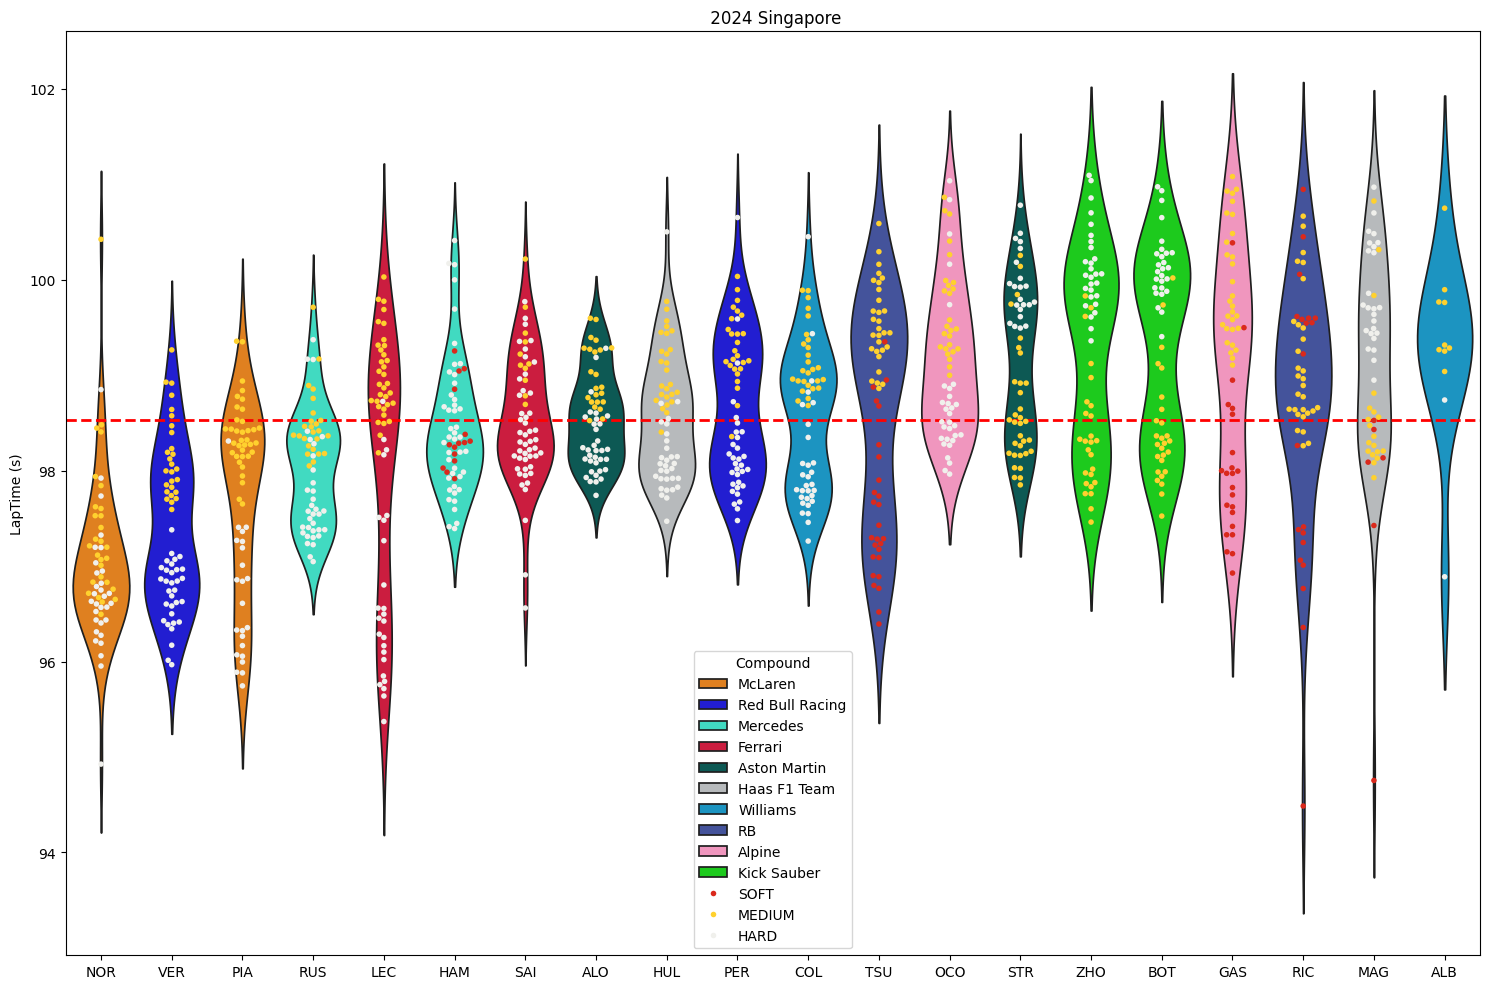

In [5]:
driver_pace_comp_violin(2024, 'Singapore')

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No c

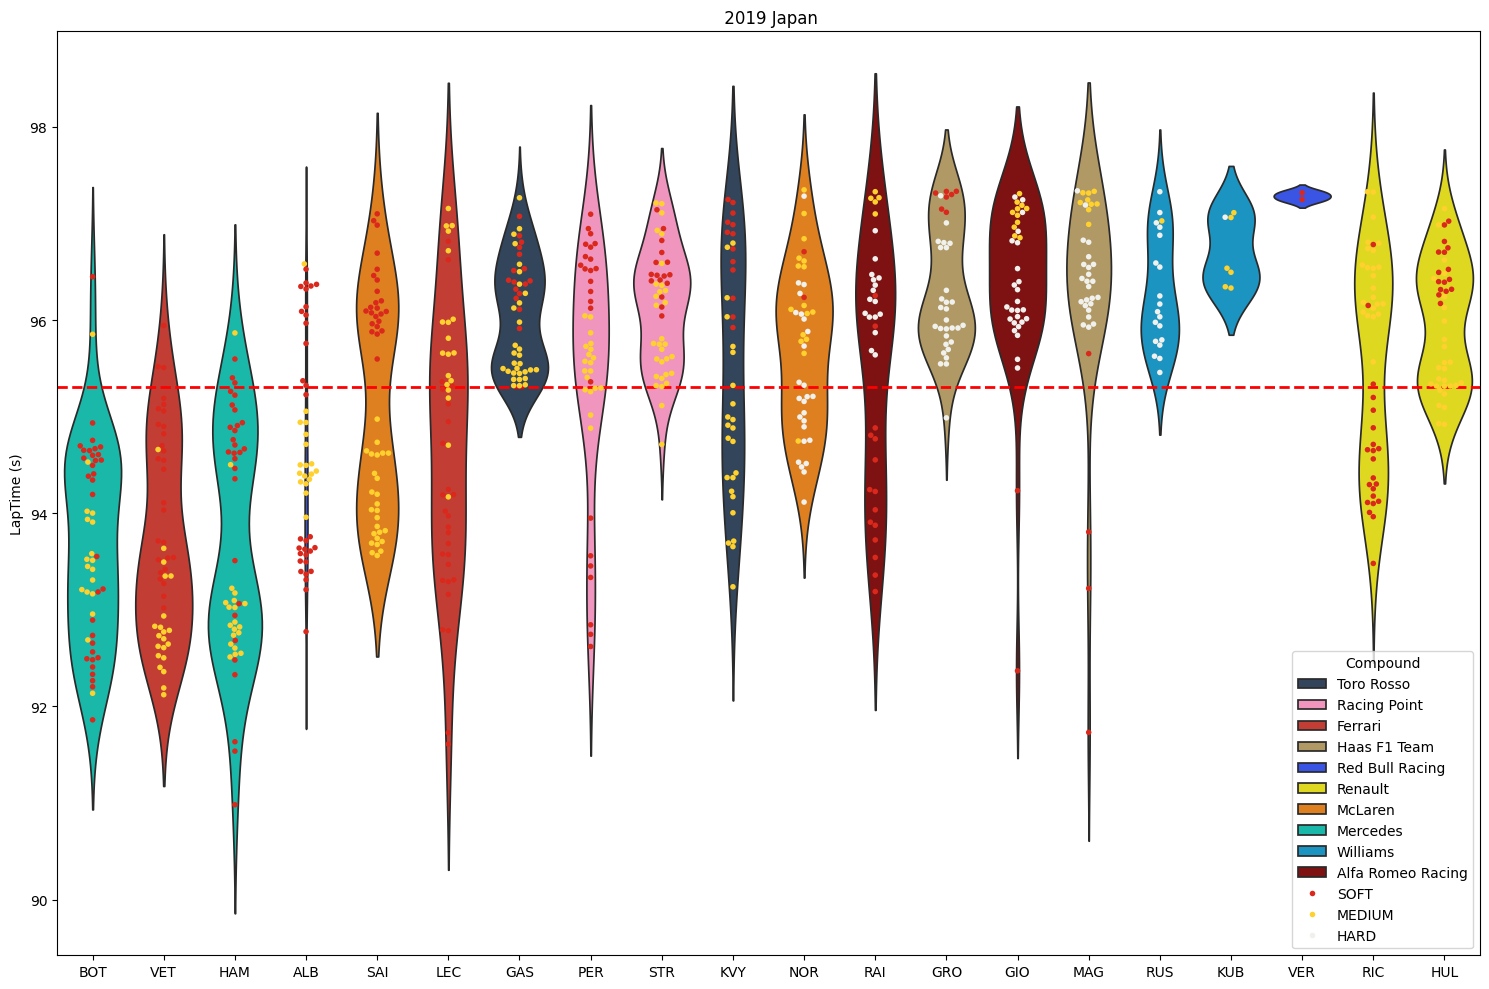

In [6]:
driver_pace_comp_violin(2019, 'Japan')

In [37]:

year_performance_driver(2024, pilotos = ['VER', 'ALO', 'NOR', 'SAI', 'PER', 'HAM', 'RUS', 'PIA', 'STR', 'LEC'])

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
req            INFO 	Using cached data for driver_info
core   

KeyboardInterrupt: 

In [ ]:
pilotos = ['VER', 'SAI', 'PER', 'HAM']

for año in range(2021, 2024):
    year_performance_driver(año, pilotos)

In [114]:
# carrera = carreras.loc[i, 'EventName']

# race = fastf1.get_session(2024, 'Azerbaijan', 'R')
# race.load()
laps = race.laps.pick_quicklaps()


transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()


# mean_lap = transformed_laps['LapTime (s)'].mean()
# transformed_laps.loc[:, "Difference"] = transformed_laps["LapTime (s)"] - mean_lap
drivers_time = transformed_laps[['LapNumber', 'Driver', 'LapTime (s)']]
mean_laps =transformed_laps[["LapNumber", "LapTime (s)"]].groupby("LapNumber").mean()

mean_laps.rename(columns={'LapTime (s)':'MeanLapTime'}, inplace = True)
drivers_time

drivers_difference = pd.merge(drivers_time, mean_laps, on= 'LapNumber', how = "inner")
drivers_difference['Difference'] = drivers_difference['LapTime (s)'] - drivers_difference['MeanLapTime']
drivers_difference

,LapNumber,Driver,LapTime (s),MeanLapTime,Difference
0,2.0,VER,109.632,110.257538,-0.625538
1,3.0,VER,109.130,110.310111,-1.180111
2,4.0,VER,109.608,109.937105,-0.329105
3,5.0,VER,109.245,109.471937,-0.226937
4,6.0,VER,108.795,109.824450,-1.029450
...,...,...,...,...,...
863,46.0,PIA,107.269,107.775889,-0.506889
864,47.0,PIA,107.060,107.680111,-0.620111
865,48.0,PIA,107.488,108.071882,-0.583882
866,49.0,PIA,107.547,108.096400,-0.549400


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
req            INFO 	Using cached data for driver_info
core  

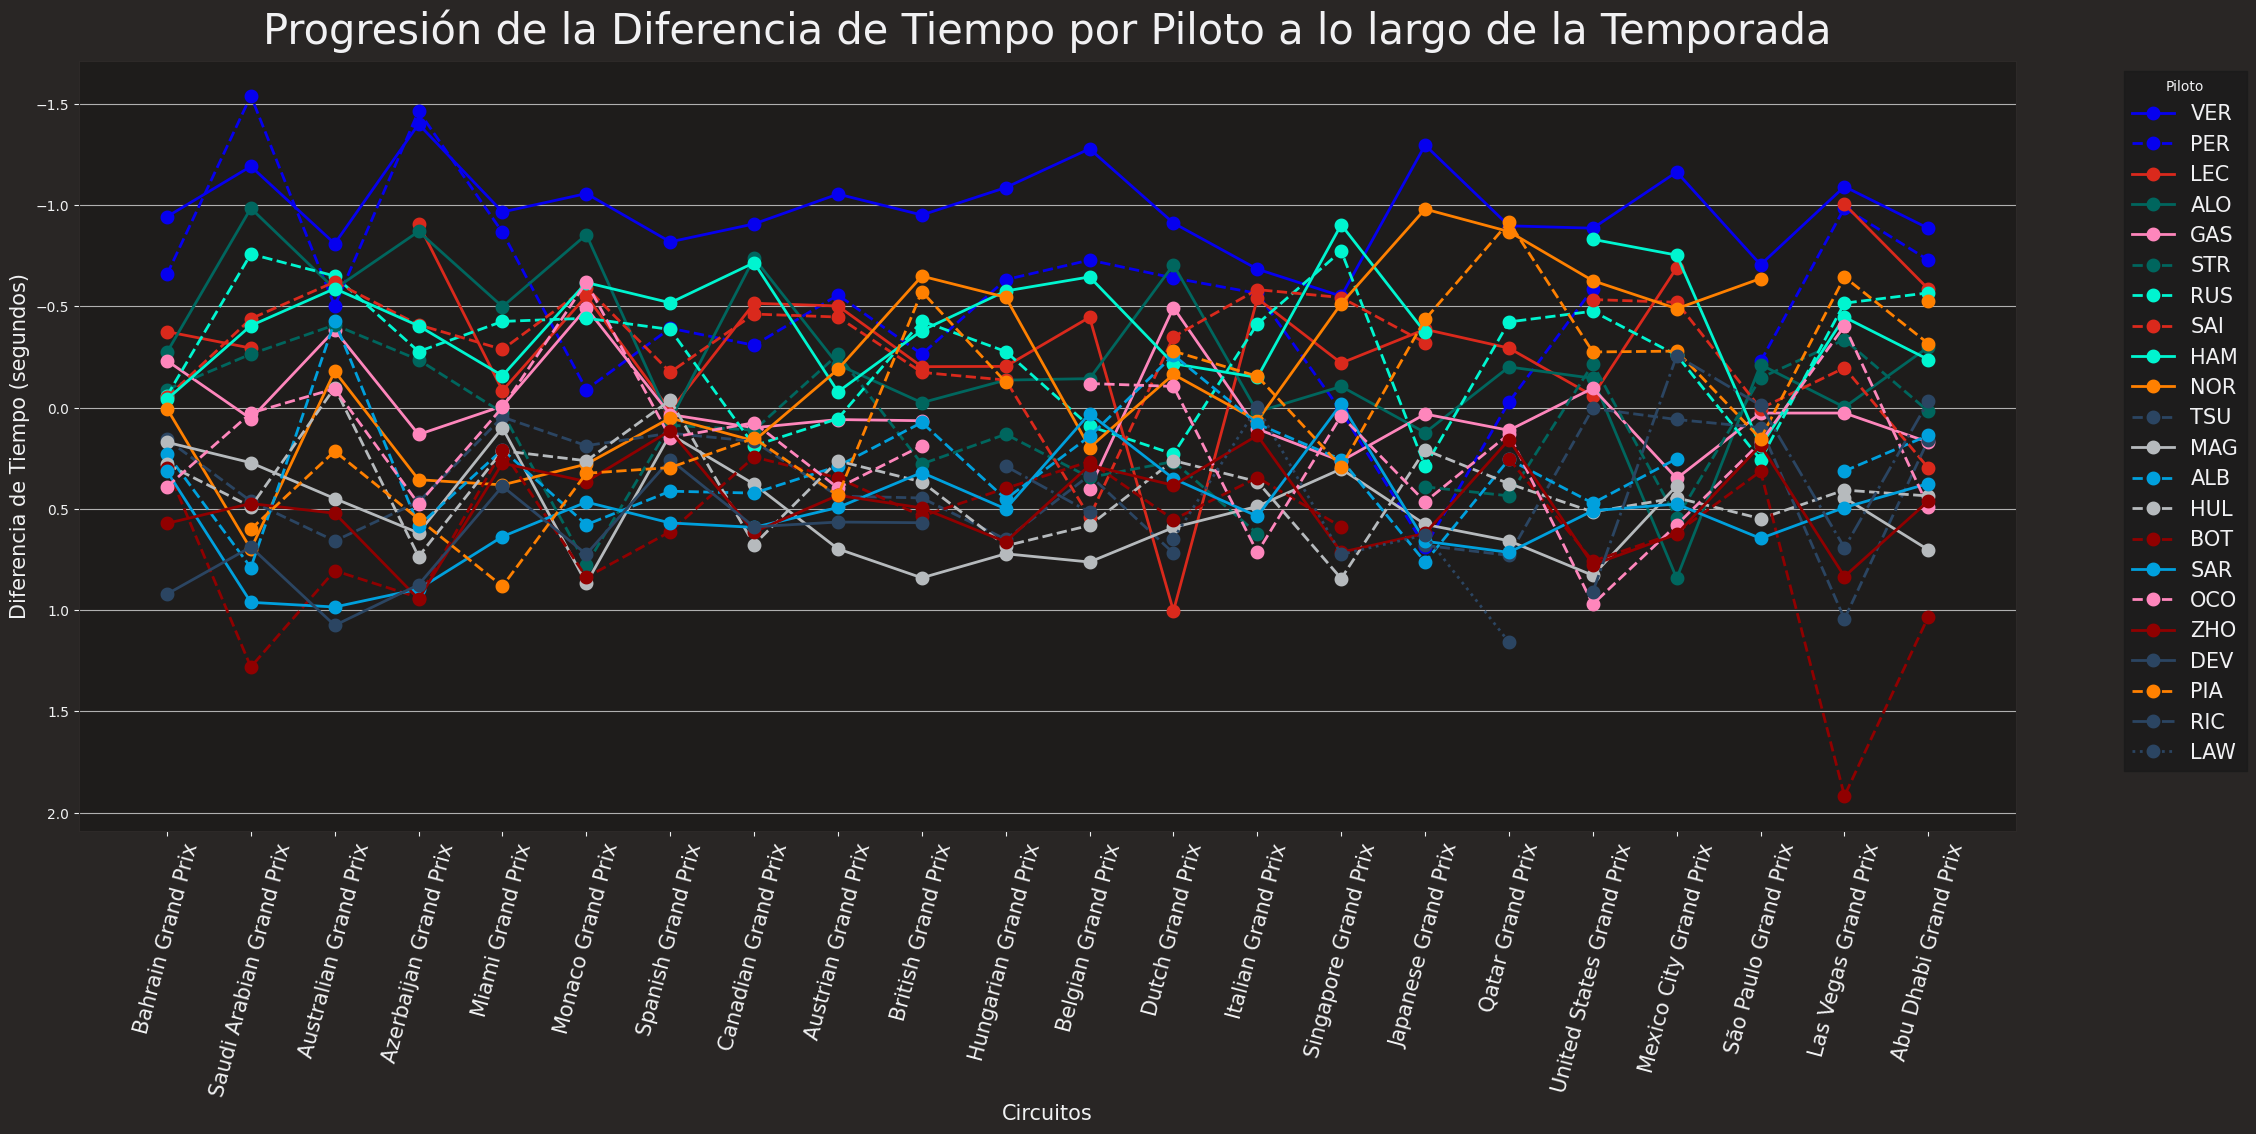

In [119]:
año = 2023


# Enable Matplotlib patches for plotting timedelta values
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                        color_scheme='fastf1')

schedule = fastf1.get_event_schedule(año)

carreras = schedule[schedule['EventName'].notna()]

mean_dif_list= []

team_drivers = {}

driver_palette = {}

driver_numero = {}

driver_linea={}

for i in range(1, len(carreras)):
    carrera = carreras.loc[i, 'EventName']

    race = fastf1.get_session(año, carrera, 'R')
    race.load()
    laps = race.laps.pick_quicklaps()

    
    transformed_laps = laps.copy()
    transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()


    drivers_time = transformed_laps[['LapNumber', 'Driver', 'LapTime (s)']]
    mean_laps =transformed_laps[["LapNumber", "LapTime (s)"]].groupby("LapNumber").mean()

    mean_laps.rename(columns={'LapTime (s)':'MeanLapTime'}, inplace = True)
    drivers_time

    drivers_difference = pd.merge(drivers_time, mean_laps, on= 'LapNumber', how = "inner")
    drivers_difference['Difference'] = drivers_difference['LapTime (s)'] - drivers_difference['MeanLapTime']


    drivers = pd.DataFrame(data = transformed_laps[['Driver', 'Team']].groupby(['Driver'], as_index=False, sort = False).max())


    for index, row in drivers.iterrows():
        piloto = row['Driver']
        equipo = row['Team']

        if equipo in team_drivers:
            if piloto not in team_drivers[equipo]:
                team_drivers[equipo].append(piloto)
        
        else:
            team_drivers[equipo] = [piloto]


    mean_dif_driver = (
        drivers_difference[["Driver", "Difference"]]
        .groupby("Driver")
        .mean()["Difference"]
        .sort_values()
        )

    mean_dif_driver = pd.Series(data = mean_dif_driver, name = carrera)

    mean_dif_list.append(mean_dif_driver)

    for driver in list(mean_dif_driver.index):
        if driver not in driver_palette.keys():
            driver_palette[driver] = fastf1.plotting.get_driver_color(driver, race)
    
for team in team_drivers.keys():
    n = 0
    for i in team_drivers[team]:
        driver_numero[i] = n
        n +=1

mean_dif_DF = pd.concat(mean_dif_list, axis = 1)


for piloto in driver_numero.keys():
    if driver_numero[piloto] == 0:
        driver_linea[piloto] = '-'
    elif driver_numero[piloto] == 1:
        driver_linea[piloto] = '--'
    elif driver_numero[piloto] == 2:
        driver_linea[piloto] = '-.'
    elif driver_numero[piloto] == 3:
        driver_linea[piloto] = ':'
    
df_t = mean_dif_DF.T  # Ahora los circuitos son el índice y los pilotos son las columnas

# Crear el gráfico de líneas

fig, ax = plt.subplots(figsize=(25, 10))

for piloto in df_t.columns:
    # if piloto not in driver_palette.index: 
    #     driver_palette[piloto] = '#000000'
    ax.plot(df_t.index, df_t[piloto], label=piloto, 
             linestyle=driver_linea[piloto], linewidth = 2,
             marker = 'o', markeredgewidth = 4, 
             color = driver_palette[piloto])  # Dibujar una línea para cada piloto
ax.set_xlabel('Circuitos', fontsize=15)
ax.set_ylabel('Diferencia de Tiempo (segundos)', fontsize=15)
ax.set_title('Progresión de la Diferencia de Tiempo por Piloto a lo largo de la Temporada', fontsize=30)
ax.set_xticks(range(len(carreras)-1), labels = df_t.index,  rotation=75, fontsize=15)  # Rotar etiquetas de los circuitos si es necesario
ax.invert_yaxis()
ax.legend(title='Piloto', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)

    # Ajustar el diseño para evitar solapamientos
# ax.tight_layout()
ax.grid(True, axis = 'y')

# Mostrar el gráfico
plt.show()



In [28]:
registro_tiempo

{'VET': [np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan)],
 'HAM': [np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan)],
 'RIC': [np.float64(nan), np.float64(nan)],
 'BOT': [np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan)],
 'RAI': [np.float64(nan)],
 'LEC': [np.float64(nan), np.float64(nan)],
 'VER': [np.float64(nan)]}

In [26]:
##FEATURE NO SE, NO VA

#QUIERO SACAR EL NUMERO DE VICTORIAS DE CADA PILOTO EN UNA FRANJA DE AÑOS, Y LA MEDIA DEL MARGEN DE VICTORIA SOBRE EL SEGUNDO
#Y LUEGO SE PLOTEA Y A VER QUE QUEDA

año_inicio = 2018
año_final = 2023


registro_tiempo = {}

n_victorias = {}

# def victoias_vs_margen(año_inicio, año_final):
for año in range(año_inicio, año_final +1):
    schedule = fastf1.get_event_schedule(año)

    carreras = schedule[schedule['EventName'].notna()]

    for n in range(1, len(carreras)):
        carrera = carreras.loc[n, 'EventName']

        race = fastf1.get_session(año, carrera, 'R')
        race.load()
        results = race.results
        results.loc[:, "Time"] = results["Time"].dt.total_seconds()

        ventaja =results['Time'][1]
        ganador = results['Abbreviation'][0]

        if ganador not in registro_tiempo:
            registro_tiempo[ganador] = [ventaja]
        else:
            registro_tiempo[ganador].append(ventaja)


for i in registro_tiempo.keys():
    n_victorias[i] = len(registro_tiempo[i])
    registro_tiempo[i] = float(st.mean(registro_tiempo[i]))


        

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data f

KeyError: 1

In [25]:
print(registro_tiempo)

print(n_victorias)

{'VER': 12.16278947368421, 'PER': 3.7460000000000004, 'SAI': 0.812}
{'VER': 19, 'PER': 2, 'SAI': 1}


In [77]:
###FEATURE 6: PERFORMANCE OVER THE YEAR

año = 2024

carrera = 'Azerbaijan'


a

Driver
PIA   -0.912461
SAI   -0.898573
PER   -0.869290
LEC   -0.780589
RUS   -0.679138
NOR   -0.562057
VER   -0.465117
HAM   -0.127268
ALO   -0.074008
HUL    0.001818
ALB    0.017028
BEA    0.120492
COL    0.150514
STR    0.574988
GAS    0.628645
BOT    0.771088
ZHO    0.874211
RIC    0.877999
OCO    1.299779
TSU    2.453402
Name: Difference, dtype: float64

TODAS LAS SESIONES DEL CALENDARIO (2024)

'Pre-Season Testing',
 'Bahrain Grand Prix',
 'Saudi Arabian Grand Prix',
 'Australian Grand Prix',
 'Japanese Grand Prix',
 'Chinese Grand Prix',
 'Miami Grand Prix',
 'Emilia Romagna Grand Prix',
 'Monaco Grand Prix',
 'Canadian Grand Prix',
 'Spanish Grand Prix',
 'Austrian Grand Prix',
 'British Grand Prix',
 'Hungarian Grand Prix',
 'Belgian Grand Prix',
 'Dutch Grand Prix',
 'Italian Grand Prix',
 'Azerbaijan Grand Prix',
 'Singapore Grand Prix',
 'United States Grand Prix',
 'Mexico City Grand Prix',
 'São Paulo Grand Prix',
 'Las Vegas Grand Prix',
 'Qatar Grand Prix',
 'Abu Dhabi Grand Prix' -->

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '27', '18', '3', '4', '77', '24', '31', '10']


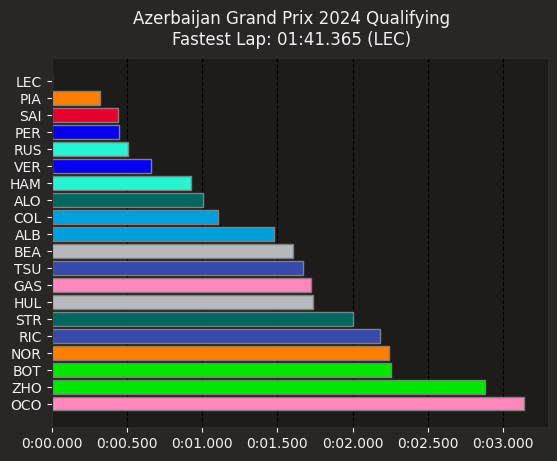

In [141]:
qual_comparision(2024, 'aZERBAIJAN')

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2024/17/results.json failed; using cached response
Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\requests_cache\session.py", line 286, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\requests_cache\session.py", line 254, in _send_and_

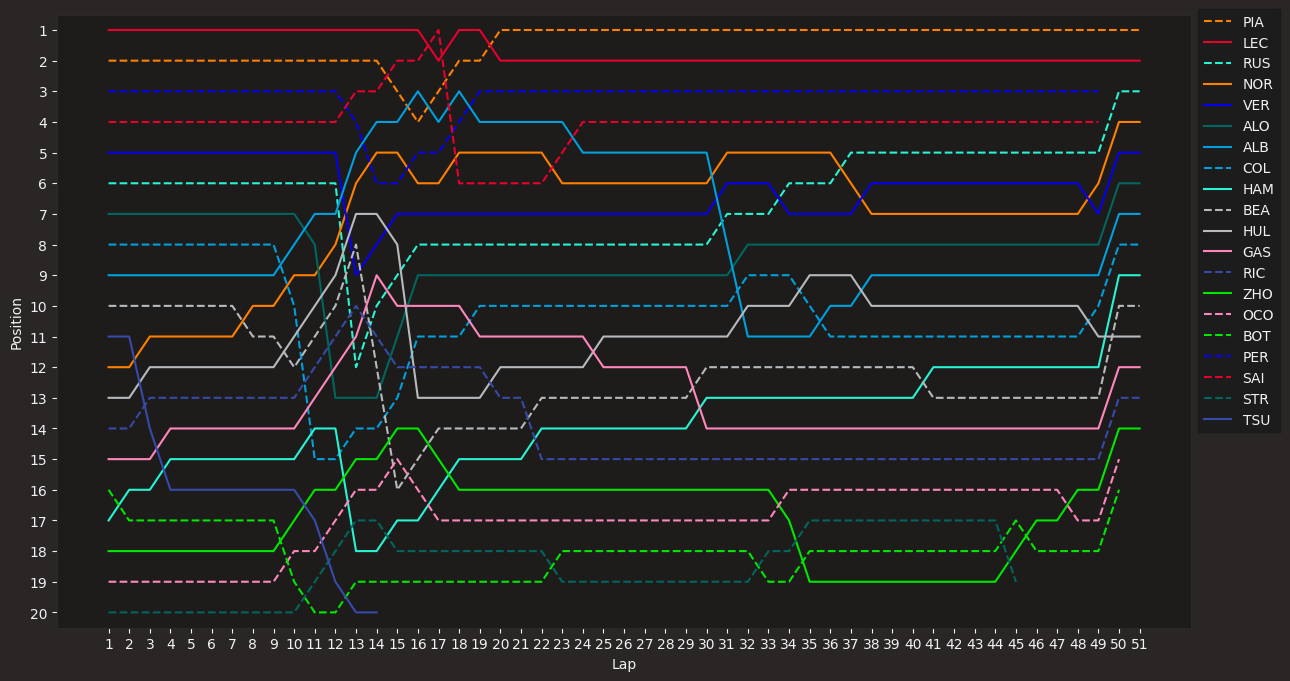

In [36]:
position_changes(2024, 'Azerbaijan')

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
req            INFO 	Data has been written to cache!
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_contr

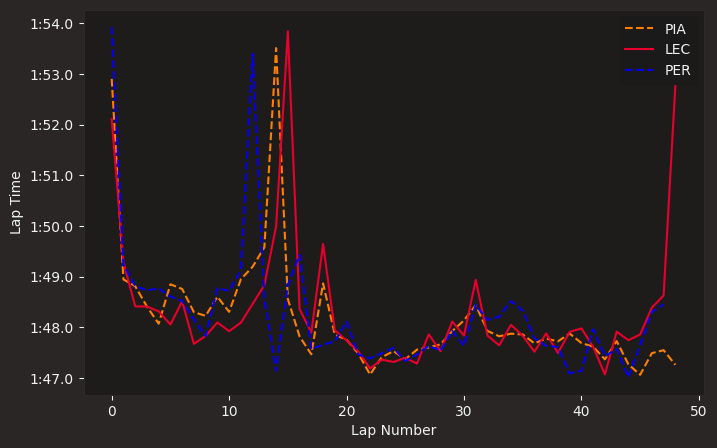

In [5]:
drivers_laptime_comp(2024, 'Azerbaijan', ['PIA', 'LEC', 'PER'])

req         WARNING 	DEFAULT CACHE ENABLED! (3.08 GB) C:\Users\Usuario\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '10', '27', '18', '3', '4', '77', '24', '31']
req     

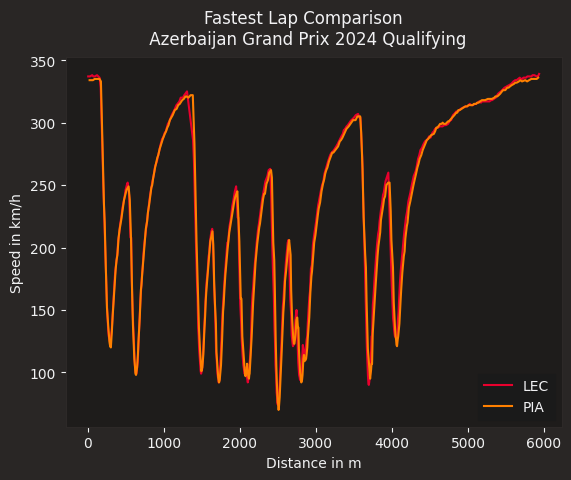

In [5]:
overlap_speed(2024, 'Azerbaijan', 'Q', 'LEC', 'PIA')

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO 	Parsing car data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for position_data. Loading data...
_api           INFO 	Fetching position data...
_api           INFO 	Parsing position data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached dat

Index(['Ferrari', 'McLaren', 'Red Bull Racing', 'Mercedes', 'Haas F1 Team',
       'Aston Martin', 'Williams', 'RB', 'Alpine', 'Kick Sauber'],
      dtype='object', name='Team')


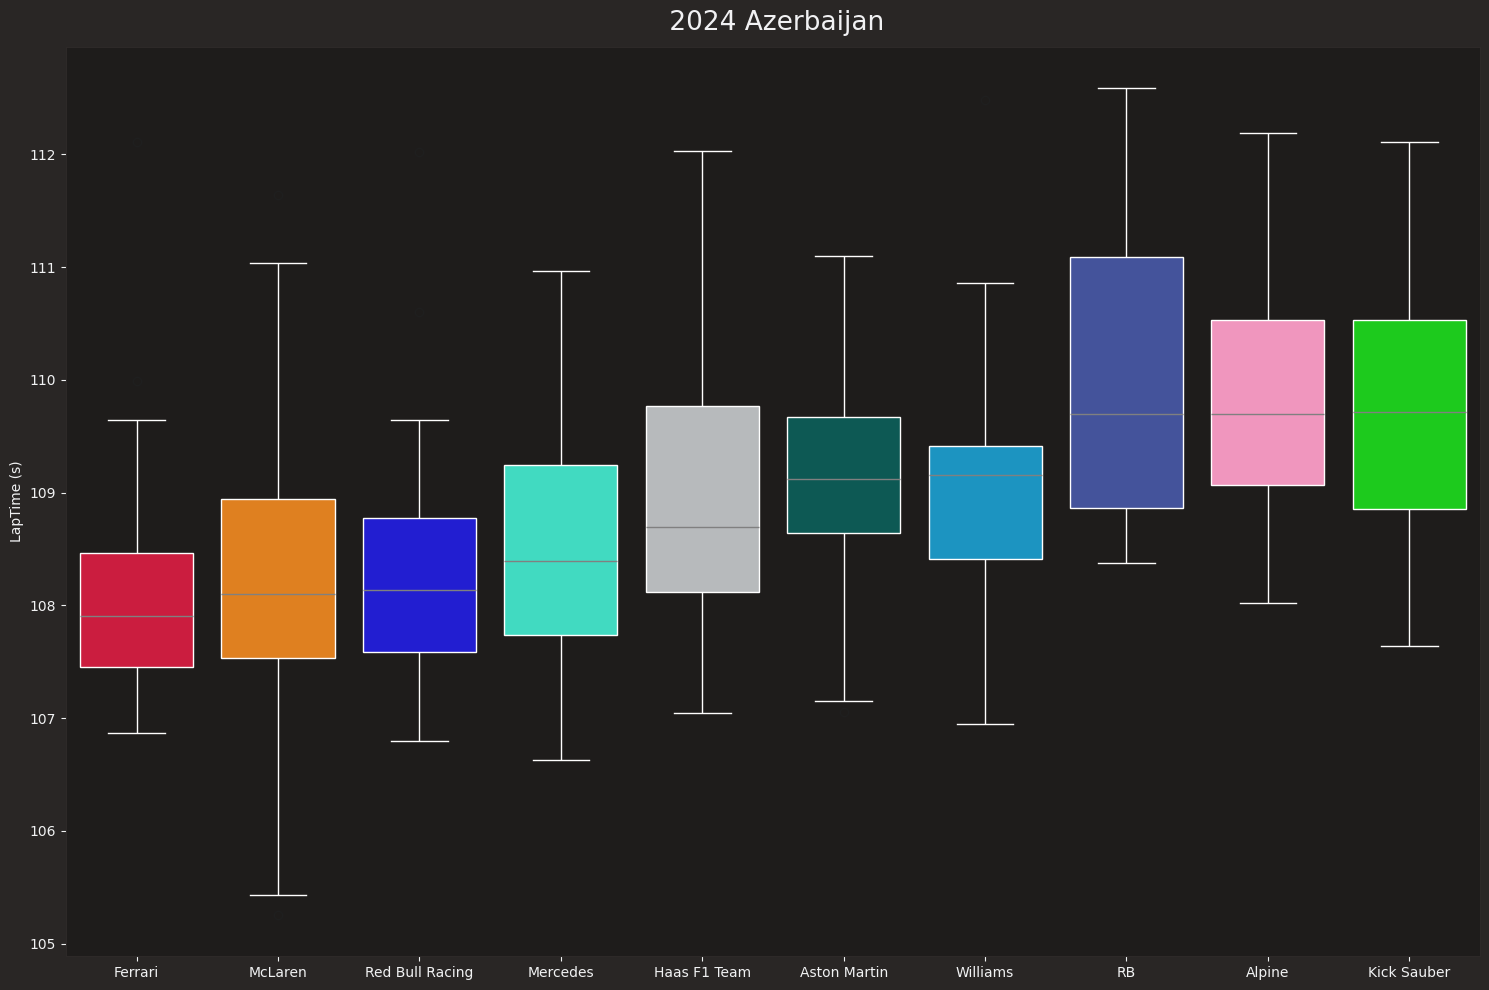

In [4]:
team_pace_comp(2024, 'Azerbaijan')